# Visualizing Eurostat data

In [1]:
import os
import sys

In [2]:
import numpy as np
import pandas as pd

import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt

import geoplot as gplt
import geoplot.crs as gcrs

from tqdm.auto import tqdm

from r_wrapper import eurostat

from bioinf_common.plotting import get_distinct_colors

In [3]:
sns.set_context('talk')

## Retrieving geographical information

The NUTS classification subdivides each member state into regions at three different levels, covering NUTS 1, 2 and 3 from larger to smaller areas (https://ec.europa.eu/eurostat/web/nuts/background).
Eurostat provides this geographical data in various formats (https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units, looks for "NUTS").

The filename of each dataset follows a specific format:  `<theme>_<spatialtype>_<resolution>_<year>_<projection>_<subset>.<extension>` (check https://ec.europa.eu/eurostat/cache/GISCO/distribution/v2/nuts/nuts-2016-files.html for more information).

To make things easier, we use the `eurostat` package to retrieve this data automatically.

In [4]:
# hide download progress output
null = open(os.devnull, 'wb')
sys.stderr = null

In [5]:
df_geo = eurostat.get_eurostat_geospatial(output_class='sf', resolution=60, nuts_level=2, year=2016)
df_geo.head()

,id,CNTR_CODE,NUTS_NAME,LEVL_CODE,FID,NUTS_ID,geometry,geo
0,DE24,DE,Oberfranken,2,DE24,DE24,"POLYGON ((11.48157 50.43162, 11.48290 50.40161...",DE24
1,NO03,NO,Sør-Østlandet,2,NO03,NO03,"POLYGON ((10.60072 60.13161, 10.57604 60.11572...",NO03
2,HU11,HU,Budapest,2,HU11,HU11,"POLYGON ((18.93274 47.57117, 19.02713 47.58717...",HU11
3,HU12,HU,Pest,2,HU12,HU12,"POLYGON ((18.96591 47.02896, 18.89943 47.07825...",HU12
4,HU21,HU,Közép-Dunántúl,2,HU21,HU21,"POLYGON ((18.68843 47.57707, 18.70448 47.52134...",HU21


In [6]:
sys.stderr = sys.__stderr__

### Example

To get a feeling for the data, we can plot the geographical composition of an arbitrary country.

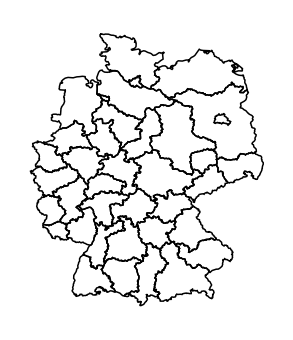

In [7]:
ax = gplt.polyplot(df_geo[df_geo['CNTR_CODE'] == 'DE'])
ax.set_aspect(1.4)

## Retrieving statistical data

Eurostat is a great source for data related to Europe.
An overview of the main tables can be found on https://ec.europa.eu/eurostat/web/regions/data/main-tables.

### Select datasets

In [8]:
eurostat.search_eurostat('age').head()

,title,code,type,last update of data,last table structure change,data start,data end,values
1,Manure storage facilities by NUTS 3 regions,aei_fm_ms,dataset,05.02.2019,27.02.2020,2000,2010,NA_character_
2,"Population on 1 January by age, sex and NUTS 2...",demo_r_d2jan,dataset,18.06.2020,16.06.2020,1990,2019,NA_character_
3,"Population on 1 January by age group, sex and ...",demo_r_pjangroup,dataset,18.06.2020,14.05.2020,1990,2019,NA_character_
4,"Population on 1 January by age group, sex and ...",demo_r_pjangrp3,dataset,14.05.2020,14.05.2020,2014,2019,NA_character_
5,"Population on 1 January by broad age group, se...",demo_r_pjanaggr3,dataset,16.06.2020,16.06.2020,1990,2019,NA_character_


In [9]:
dataset_list = [
    'tgs00101',  # life expectancy
    'tgs00026',  # exposable income
    'tgs00036',  # primary income
    'tgs00010',  # unemployment rate
    'tgs00112',  # touristic bed number
]

### Download and aggregate data

To make the subsequent analysis easier, we download all data at once and store it in a single dataframe.
Additionally, we store associated meta data in another dataframe.

In [10]:
# hide download progress output
null = open(os.devnull, 'wb')
sys.stderr = null

In [11]:
df_list = []
meta_list = []

for dataset in tqdm(dataset_list):
    # get dataset description
    dataset_name = eurostat.label_eurostat_tables(dataset)[0]
    print(f'Parsing {dataset} ({dataset_name})')
    
    # retrieve data
    df_data = eurostat.get_eurostat(dataset, time_format='raw')
    df_data = eurostat.label_eurostat(df_data, code=['geo'], fix_duplicated=True)

    # index rows
    common_columns = ['geo_code', 'geo']
    df_data['idx'] = df_data[common_columns].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    
    # identify meta information
    info_columns = set(df_data.columns) - set(common_columns) - {'idx', 'time', 'values', 'info', 'info_short'}
    
    meta_cols = [';'.join(f'{k}={row._asdict()[k]}' for k in sorted(row._asdict().keys()) if k != 'Index') for row in df_data[info_columns].itertuples()]
    meta_idx, meta_label = pd.factorize(meta_cols)
    
    df_data['meta'] = [f'{dataset}_{time}_{x}' for x, time in zip(meta_idx, df_data['time'])]

    # pivot data
    df_piv = df_data.pivot(index='idx', columns='meta', values='values')
    
    # store data
    df_list.append(df_piv)

    meta_list.extend([{
        'dataset': dataset,
        'name': dataset_name,
        'meta_idx': idx,
        'meta_label': label,
    } for idx, label in zip(np.unique(meta_idx), meta_label)])

Parsing tgs00101 (Life expectancy at birth by sex and NUTS 2 region)


Parsing tgs00026 (Disposable income of private households by NUTS 2 regions)


Parsing tgs00036 (Primary income of private households by NUTS 2 regions)


Parsing tgs00010 (Unemployment rate by NUTS 2 regions)


Parsing tgs00112 (Number of establishments and bed-places by NUTS 2 regions)


Each row corresponds to a geographic region, and each column to a certain statistic.

In [12]:
sys.stderr = sys.__stderr__

In [13]:
df_all = pd.concat(df_list, axis=1)
df_all.head()

meta,tgs00101_2007_0,tgs00101_2007_1,tgs00101_2007_2,tgs00101_2008_0,tgs00101_2008_1,tgs00101_2008_2,tgs00101_2009_0,tgs00101_2009_1,tgs00101_2009_2,tgs00101_2010_0,...,tgs00112_2015_0,tgs00112_2015_1,tgs00112_2016_0,tgs00112_2016_1,tgs00112_2017_0,tgs00112_2017_1,tgs00112_2018_0,tgs00112_2018_1,tgs00112_2019_0,tgs00112_2019_1
AT11_Burgenland (AT),83.3,76.2,79.7,83.4,76.7,80.0,84.2,77.5,80.9,83.9,...,28414.0,436.0,28252.0,427.0,28293.0,427.0,27551.0,418.0,27404.0,412.0
AT12_Niederösterreich,82.7,77.0,79.9,82.8,77.1,80.0,82.7,77.4,80.1,83.3,...,68399.0,1459.0,68714.0,1429.0,67465.0,1434.0,67868.0,1435.0,68246.0,1447.0
AT13_Wien,82.0,76.7,79.5,82.4,77.0,79.9,82.1,76.5,79.4,82.2,...,73901.0,604.0,74771.0,1072.0,75462.0,1212.0,78672.0,1735.0,79245.0,2070.0
AT21_Kärnten,83.6,77.8,80.8,84.1,77.7,81.0,83.7,77.7,80.8,84.0,...,142508.0,2765.0,141191.0,2695.0,140473.0,2717.0,140448.0,2720.0,140165.0,2716.0
AT22_Steiermark,83.6,77.6,80.7,83.7,77.5,80.6,83.5,77.6,80.6,83.9,...,112499.0,2432.0,116262.0,2471.0,118592.0,2471.0,125850.0,2481.0,128815.0,2521.0


Extra information for each column is stored in an additional dataframe.

In [14]:
df_meta = pd.DataFrame(meta_list)
df_meta.head()

,dataset,name,meta_idx,meta_label
0,tgs00101,Life expectancy at birth by sex and NUTS 2 region,0,age=Less than 1 year;sex=Females;unit=Year
1,tgs00101,Life expectancy at birth by sex and NUTS 2 region,1,age=Less than 1 year;sex=Males;unit=Year
2,tgs00101,Life expectancy at birth by sex and NUTS 2 region,2,age=Less than 1 year;sex=Total;unit=Year
3,tgs00026,Disposable income of private households by NUT...,0,"direct=Balance;na_item=Disposable income, net;..."
4,tgs00036,Primary income of private households by NUTS 2...,0,direct=Balance;na_item=Balance of primary inco...


In [15]:
def get_meta(col_name, extended=False):
    dataset, time, idx = col_name.split('_')
    res = df_meta[(df_meta['dataset'] == dataset) & (df_meta['meta_idx'] == int(idx))]
    assert res.shape[0] == 1
    res = res.iloc[0]
    
    if extended:
        return f'{res["name"]}\n({res["meta_label"]})'
    else:
        return res["name"]

### Overview

To get a rough overview of the data, we can plot the clustered correlation matrix.

In [16]:
df_corr = df_all.corr()

In [17]:
non_nan_datasets = set(df_corr.dropna(axis=0).index) & set(df_corr.dropna(axis=1).columns)
df_corr = df_corr.loc[non_nan_datasets, non_nan_datasets]

In [18]:
# assign unique color to each data source
cluster_names = df_all.columns.str.split('_').str[0].unique()
cluser_colors = get_distinct_colors(len(cluster_names))
cluster_map = {n: c for n, c in zip(cluster_names, cluser_colors)}
cluster_colors = pd.DataFrame([(col, cluster_map[col.split('_')[0]]) for col in df_all.columns]).set_index(0)[1]

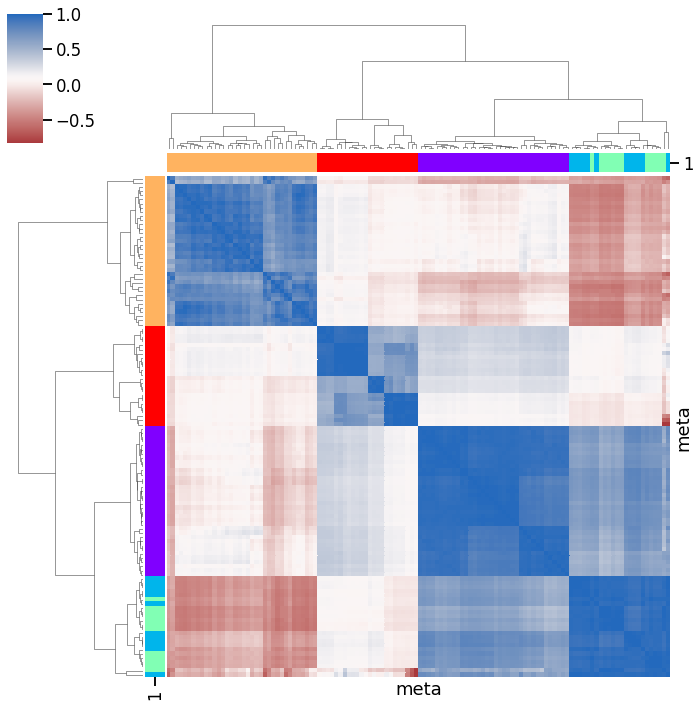

In [19]:
g = sns.clustermap(
    df_corr,
    xticklabels=False, yticklabels=False,
    cmap='vlag_r',
    row_colors=cluster_colors, col_colors=cluster_colors
)

## Data preparation

In order to combine both geographical and statistical data, we merge the data...

In [20]:
df_all['geo_code'] = [idx.split('_')[0] for idx in df_all.index]

In [21]:
df_merged = df_geo.merge(df_all, left_on='NUTS_ID', right_on='geo_code')
df_merged.head()

,id,CNTR_CODE,NUTS_NAME,LEVL_CODE,FID,NUTS_ID,geometry,geo,tgs00101_2007_0,tgs00101_2007_1,...,tgs00112_2015_1,tgs00112_2016_0,tgs00112_2016_1,tgs00112_2017_0,tgs00112_2017_1,tgs00112_2018_0,tgs00112_2018_1,tgs00112_2019_0,tgs00112_2019_1,geo_code
0,DE24,DE,Oberfranken,2,DE24,DE24,"POLYGON ((11.48157 50.43162, 11.48290 50.40161...",DE24,82.2,76.7,...,890.0,40555.0,876.0,40804.0,869.0,40049.0,863.0,41574.0,865.0,DE24
1,NO03,NO,Sør-Østlandet,2,NO03,NO03,"POLYGON ((10.60072 60.13161, 10.57604 60.11572...",NO03,82.3,77.7,...,464.0,143032.0,455.0,142724.0,421.0,151654.0,413.0,NaN,NaN,NO03
2,HU11,HU,Budapest,2,HU11,HU11,"POLYGON ((18.93274 47.57117, 19.02713 47.58717...",HU11,78.7,72.4,...,342.0,57210.0,359.0,NaN,NaN,56213.0,375.0,58711.0,379.0,HU11
3,HU12,HU,Pest,2,HU12,HU12,"POLYGON ((18.96591 47.02896, 18.89943 47.07825...",HU12,77.9,69.8,...,229.0,16348.0,232.0,NaN,NaN,17816.0,248.0,16927.0,240.0,HU12
4,HU21,HU,Közép-Dunántúl,2,HU21,HU21,"POLYGON ((18.68843 47.57707, 18.70448 47.52134...",HU21,77.8,69.4,...,610.0,63641.0,625.0,65846.0,651.0,70627.0,685.0,69919.0,692.0,HU21


...and dissolve it to reach a resolution which leads to a nice visualization.

In [22]:
%%time
df_diss = df_merged.dissolve(by='CNTR_CODE', aggfunc='mean')

CPU times: user 567 ms, sys: 4.7 ms, total: 572 ms
Wall time: 575 ms


In [23]:
df_diss.head()

,geometry,LEVL_CODE,tgs00101_2007_0,tgs00101_2007_1,tgs00101_2007_2,tgs00101_2008_0,tgs00101_2008_1,tgs00101_2008_2,tgs00101_2009_0,tgs00101_2009_1,...,tgs00112_2015_0,tgs00112_2015_1,tgs00112_2016_0,tgs00112_2016_1,tgs00112_2017_0,tgs00112_2017_1,tgs00112_2018_0,tgs00112_2018_1,tgs00112_2019_0,tgs00112_2019_1
CNTR_CODE,,,,,,,,,,,,,,,,,,,,,
AT,"POLYGON ((15.99624 46.83540, 15.98885 46.82563...",2,83.366667,77.611111,80.566667,83.622222,77.977778,80.866667,83.600000,77.844444,...,110385.000000,2257.222222,111271.333333,2291.000000,112577.666667,2320.555556,116181.888889,2388.222222,115356.444444,2439.000000
BE,"POLYGON ((6.02490 50.18278, 5.97197 50.17189, ...",2,82.581818,76.909091,79.790909,82.536364,76.627273,79.600000,82.672727,77.190909,...,33499.272727,726.363636,33497.090909,746.363636,33982.000000,779.090909,35438.727273,837.363636,35962.272727,877.363636
BG,"POLYGON ((26.56154 41.92627, 26.58121 41.90292...",2,76.466667,69.400000,72.833333,76.850000,69.683333,73.133333,77.183333,70.000000,...,53744.166667,533.666667,54710.666667,555.166667,58120.666667,557.666667,55932.833333,576.333333,56917.666667,610.666667
CH,"POLYGON ((9.15938 46.16960, 9.12055 46.13610, ...",2,84.557143,79.614286,82.185714,84.785714,79.942857,82.471429,84.742857,80.014286,...,NaN,NaN,97329.571429,5902.714286,NaN,NaN,94951.857143,5579.571429,NaN,NaN
CY,"POLYGON ((33.75237 34.97711, 33.70164 34.97605...",2,82.100000,77.600000,79.800000,82.900000,78.200000,80.600000,83.500000,78.500000,...,85414.000000,788.000000,84239.000000,785.000000,85965.000000,796.000000,87240.000000,802.000000,90188.000000,816.000000


## Visualization

We visualize the data using choropleth maps. By doing so, each geographical region is colored according to a statistic of interest.

In the following, we will use a single entry from each downloaded dataset.

In [24]:
time = 2016
hue_selection = [f'{row.dataset}_{time}_{row.meta_idx}' 
                 for row in df_meta.groupby('dataset').apply(lambda x: x.sample(n=1)).itertuples()]
hue_selection

['tgs00010_2016_2',
 'tgs00026_2016_0',
 'tgs00036_2016_0',
 'tgs00101_2016_1',
 'tgs00112_2016_1']

### Single country

We can get a precise overview of individual regions within a single country.

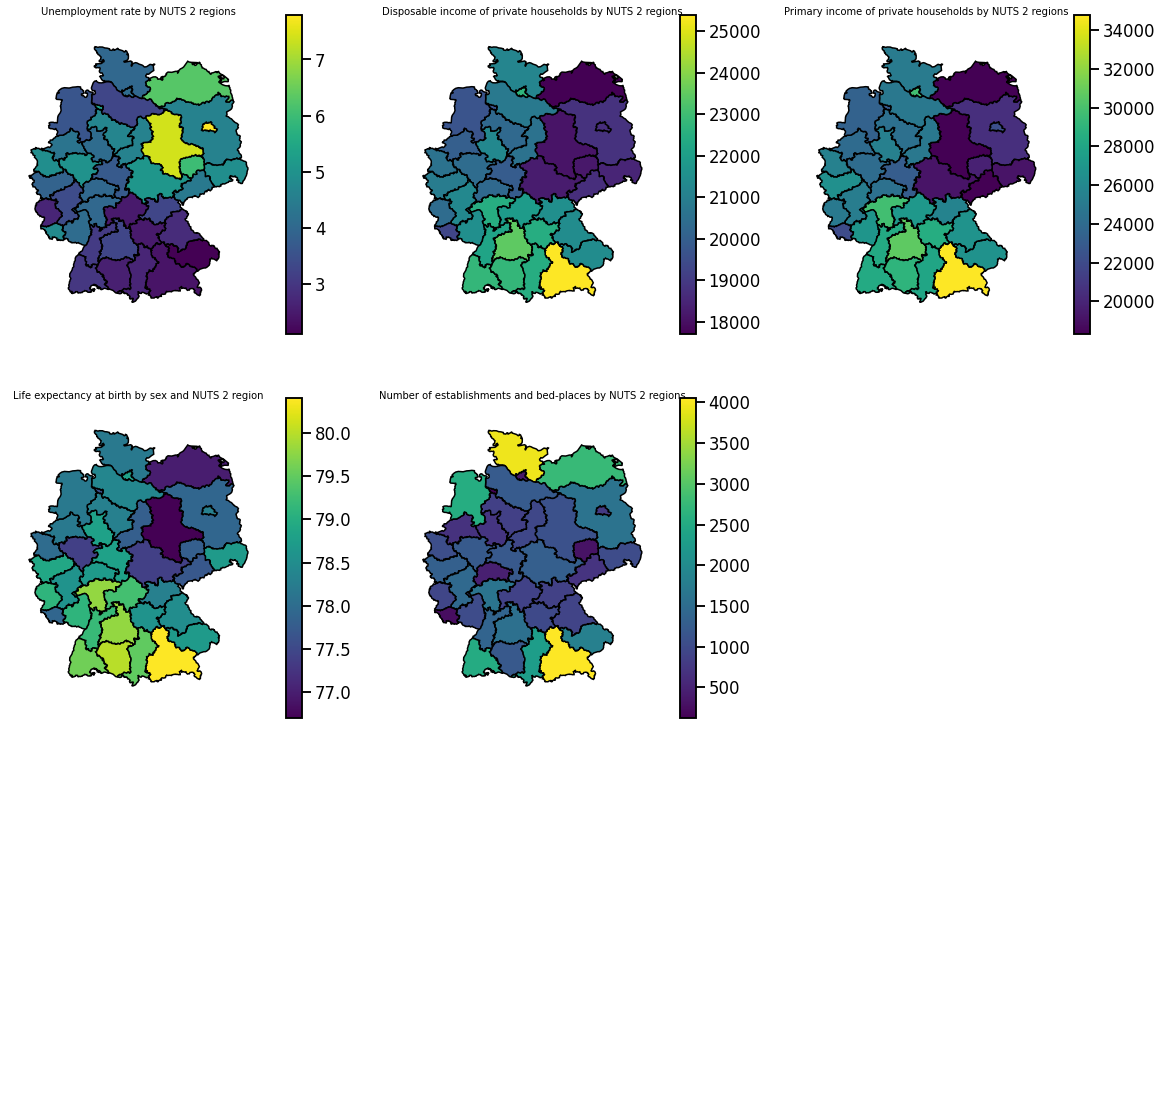

In [25]:
size = int(np.ceil(np.sqrt(len(hue_selection))))  # size of plot grid

fig, axes = plt.subplots(nrows=size, ncols=size, figsize=(20, 20))
[ax.axis('off') for ax in axes.ravel()]

for hue, ax in zip(hue_selection, axes.ravel()):
    sub = df_merged[(df_merged['CNTR_CODE'] == 'DE')]
    
    gplt.choropleth(sub, hue=hue, legend=True, ax=ax)
    ax.set_aspect(1.4)
    ax.set_title(get_meta(hue), fontsize=10)

### Europe

To get a more global picture, we can also plot the aggregated data per country.

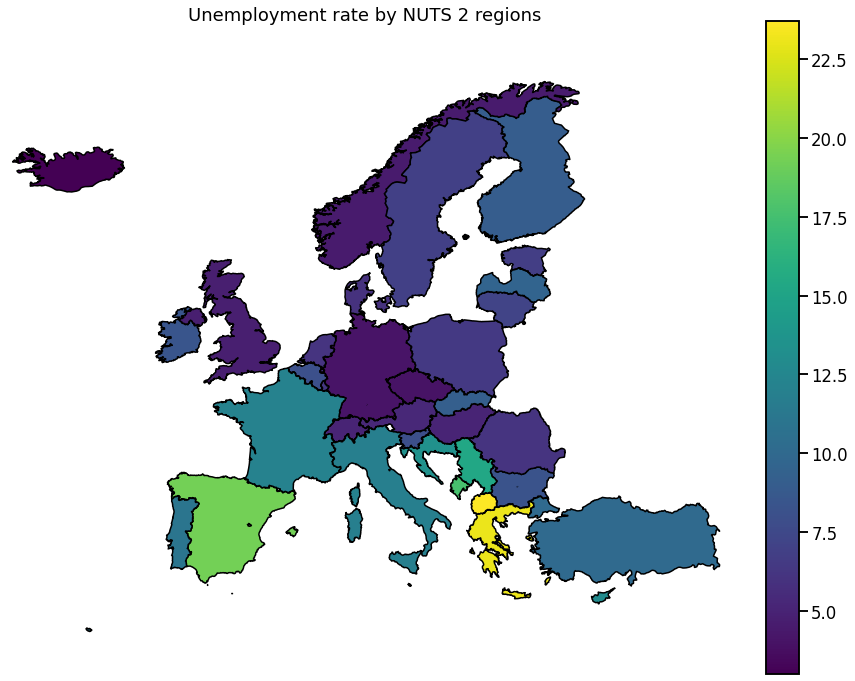

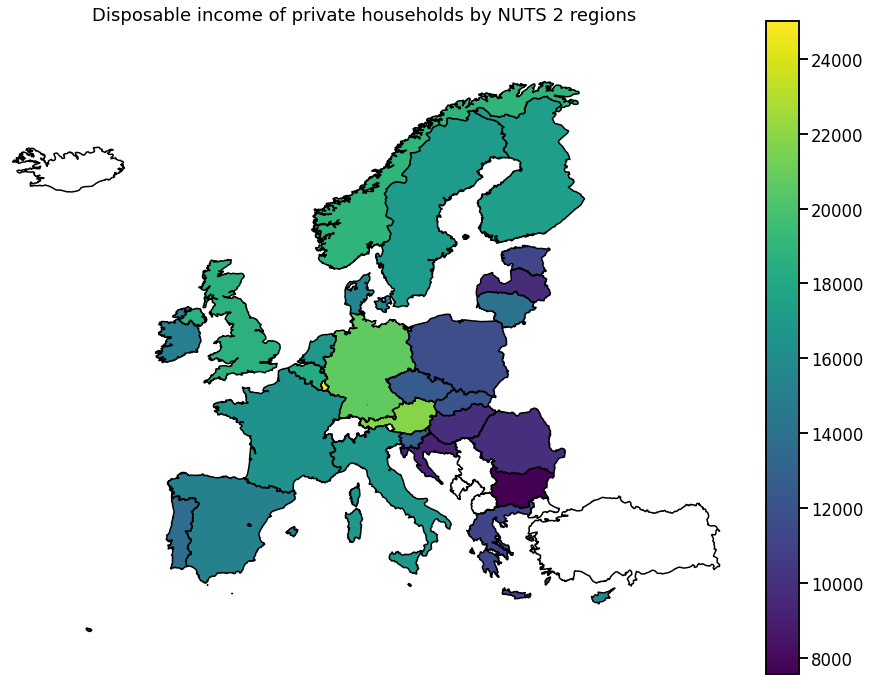

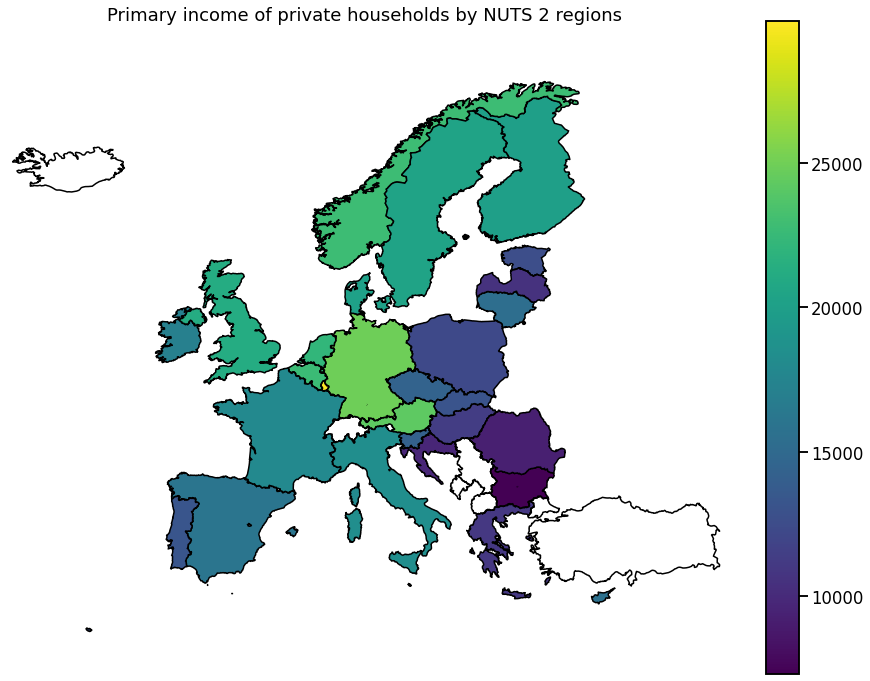

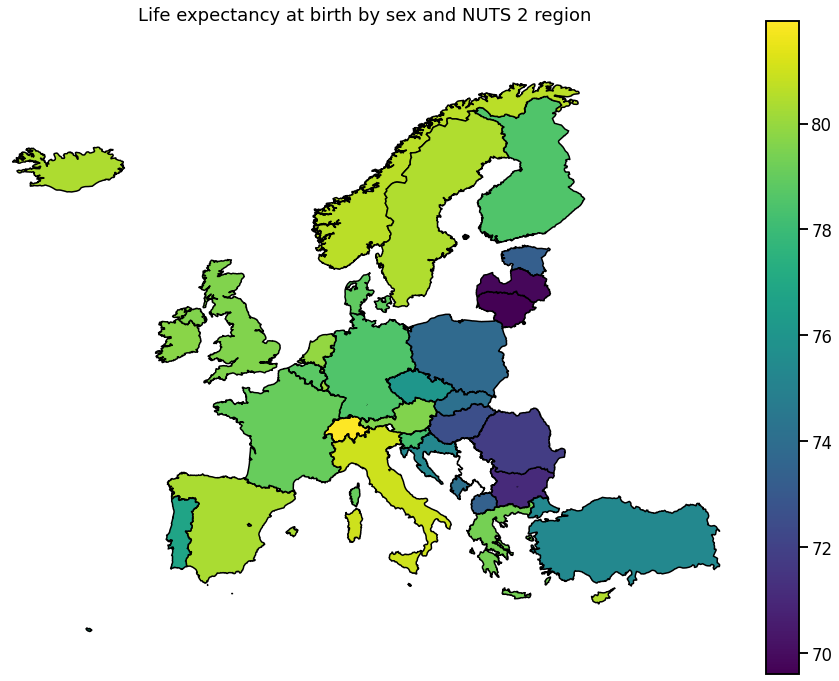

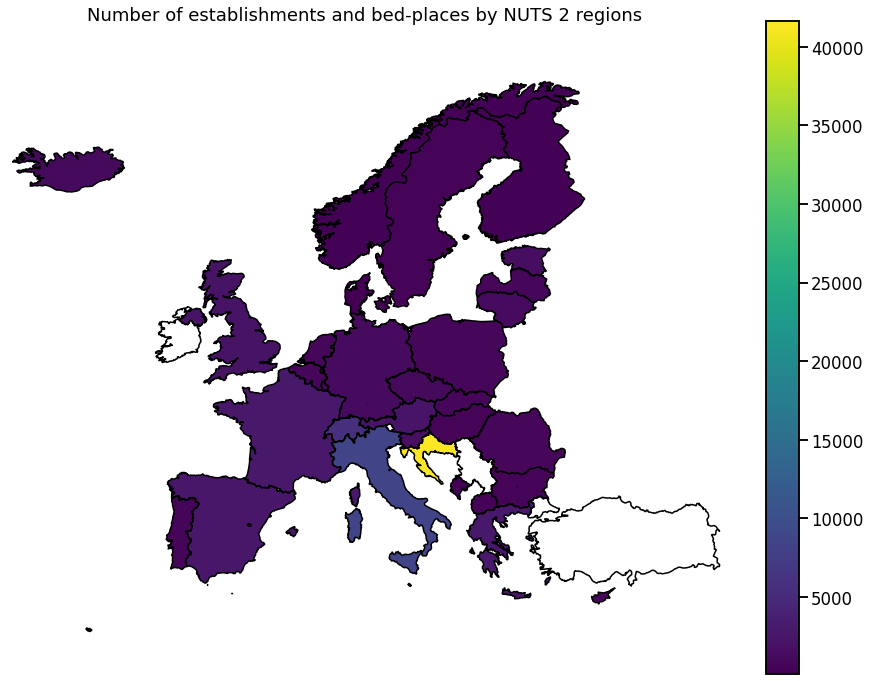

In [26]:
for hue in hue_selection:
    ax = gplt.choropleth(
        df_diss, hue=hue,
        legend=True, #k=5,
        figsize=(16, 12),
        extent=(-25, 30, 45, 75),  # (min_longitude, min_latitude, max_longitude, max_latitude)
    )
    ax.set_aspect(1.4)
    ax.set_title(get_meta(hue))